# M5 Forecasting - Accuracy
### https://www.kaggle.com/competitions/m5-forecasting-accuracy/

### Necessary Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from downcast import reduce
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm

# Problem Understanding

The competition guidelines provide the basic necessary information, both about the available data, as well as our goal. Using sales data from the past years, our objective is to create a prediction model that will forecast future Walmart sales for the subsequent 28 days. Our training set consists of 1914 days worth of data (roughly 5 years) from the states of California, Winsconsis and Texas. The files provided by the competition organizers are as follows:

    1. calendar.csv - Contains information about the dates on which the products are sold.
    2. sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 d_1913]
    3. sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
    4. sell_prices.csv - Contains information about the price of the products sold per store and date.
    5. sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)
    
The accuracy of our prediction will be judged based off of a Weighted Root Mean Squared Scaled Error (WRMSSE) score, an implementation of which is provided below:

In [2]:
#Implementation of WRMSSE by sakami
#https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834


class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())

        return np.mean(all_scores)

# Determining potential sales factors based on the provided dataset

#### 1. Price
Prices are an obvious factor in determining the amount of sales, specifically in relation to location and events.

#### 2. Product Category
The distinction between certain types of products is an important factor in our predictions, as certain conditions may impact specific categories differently from others.

#### 3. Date
We can expect sales to vary depending on both the day of the week as well as the month. Weekends likely see more sales than weekdays, and specific months can have impact due to holidays, general weather conditions (for hobbies etc) or product availibility (specifically in the food industry). Years may be useful in determining general trends, but they represent a portion of the dataset that is far too large to be useful in a prediction of 28 days.

#### 4. Special events and holidays
Specfic events are going to impact sales, either outright or in specific categories. This can be both negative and positive, their impact may also vary by state.

#### 5. Location
Specific states are likely to impact sales due mainly due to differences in population and wealth. This, while a solid general assumption, may however be a flawed hypothesis due to the available data coming from a relatively small amount of stores. The population density, wealth and local competition, all data that is not provided, may both diminish or exacerbate the impact of these factors. States also vary in cultural diversity and religiousness, which could affect the impact of certain special events. 

# Exploratory Data Analysis

We will now look to examine the provided data in order to observe the impact of the outlined factors. We may also look to reevaluate the assumptions stemming from our domain knowledge.

In [3]:
#Read in data

calendar = pd.read_csv('input/calendar.csv', parse_dates=['date'])
sell_prices = pd.read_csv('input/sell_prices.csv')
sales = pd.read_csv('input/sales_train_evaluation.csv')
sales_valid = pd.read_csv('input/sales_train_validation.csv')

In [4]:
#Due to large filesizes we will use downcast to reduce filesize without impacting provided data
calendar = reduce(calendar)
sell_prices = reduce(sell_prices)
sales = reduce(sales)
sales_valid = reduce(sales_valid)

## Calendar



Notes from the official guide

File 1: “calendar.csv” Contains information about the dates the products are sold.

    date: The date in a “y-m-d” format.
    wm_yr_wk: The id of the week the date belongs to.
    weekday: The type of the day (Saturday, Sunday, …, Friday).
    wday: The id of the weekday, starting from Saturday.
    month: The month of the date.
    year: The year of the date.
    event_name_1: If the date includes an event, the name of this event.
    event_type_1: If the date includes an event, the type of this event.
    event_name_2: If the date includes a second event, the name of this event.
    event_type_2: If the date includes a second event, the type of this event.
    snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP purchases on the examined date. 1 indicates that SNAP purchases are allowed.



In [5]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [6]:
calendar.describe()

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


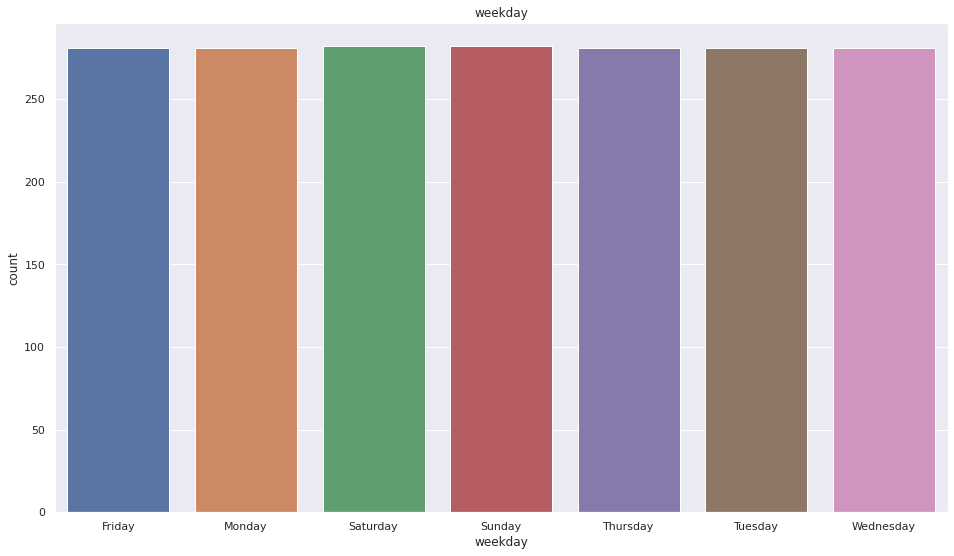

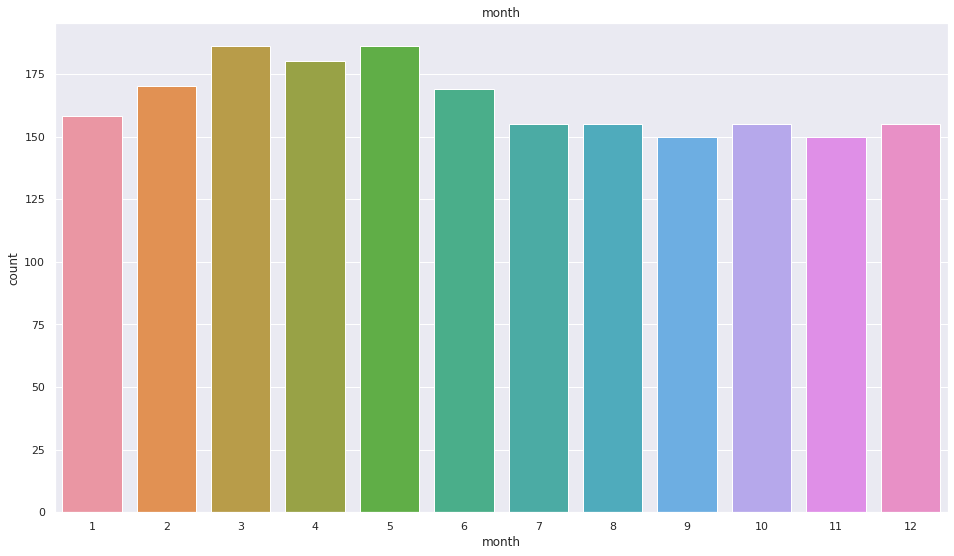

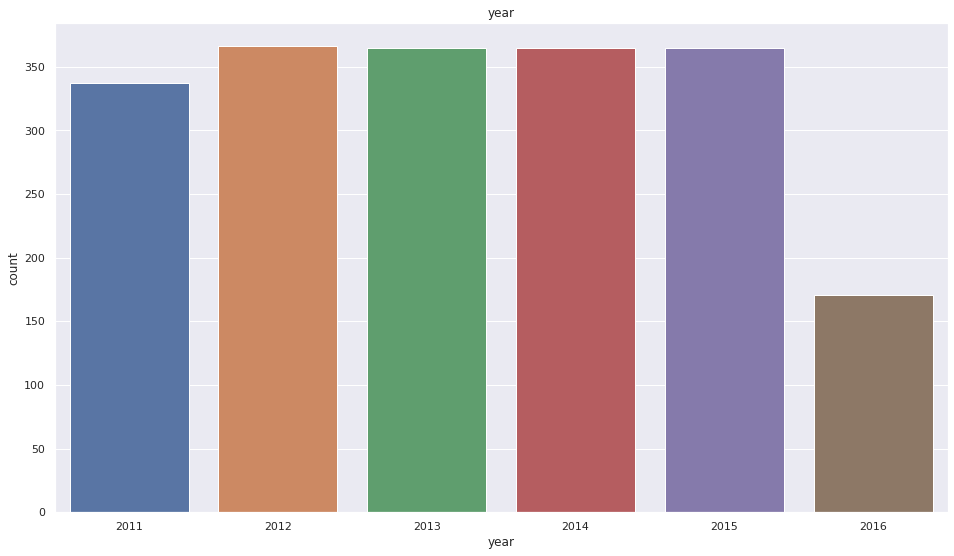

In [7]:
#validate counts
sns.set(rc = {'figure.figsize':(16,9)})
for feature in ['weekday','month','year']:
    sns.countplot(x=calendar[feature], data=calendar)
    plt.xticks(rotation=0)
    plt.title(feature)
    plt.show()


Day counts being equal suggests we are unlikely to have missing entries. The differences in month count are explained by the data not starting/ending on the same month. 

### Events

Let us check the counts for specific events and how many events fall in each category.

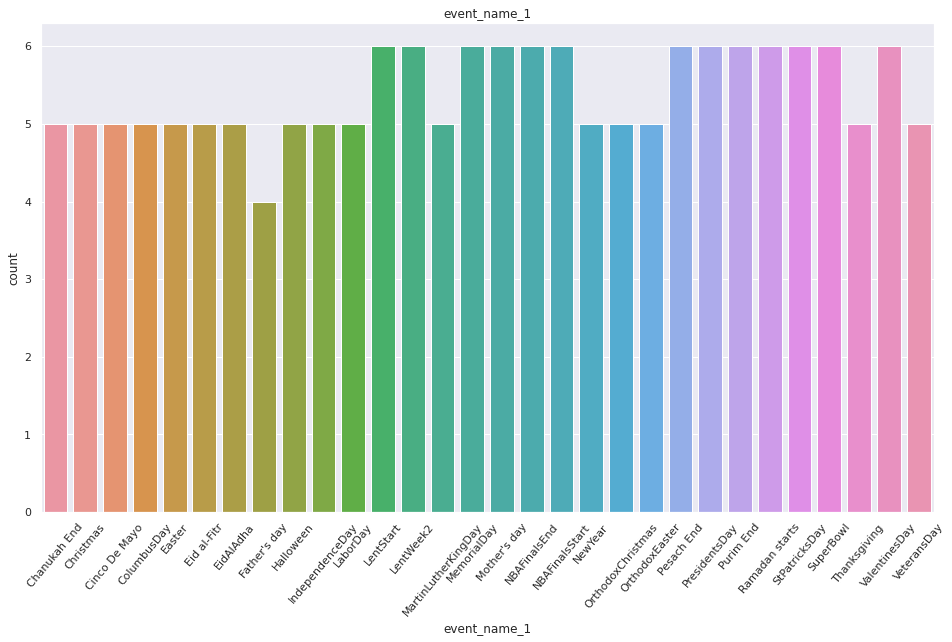

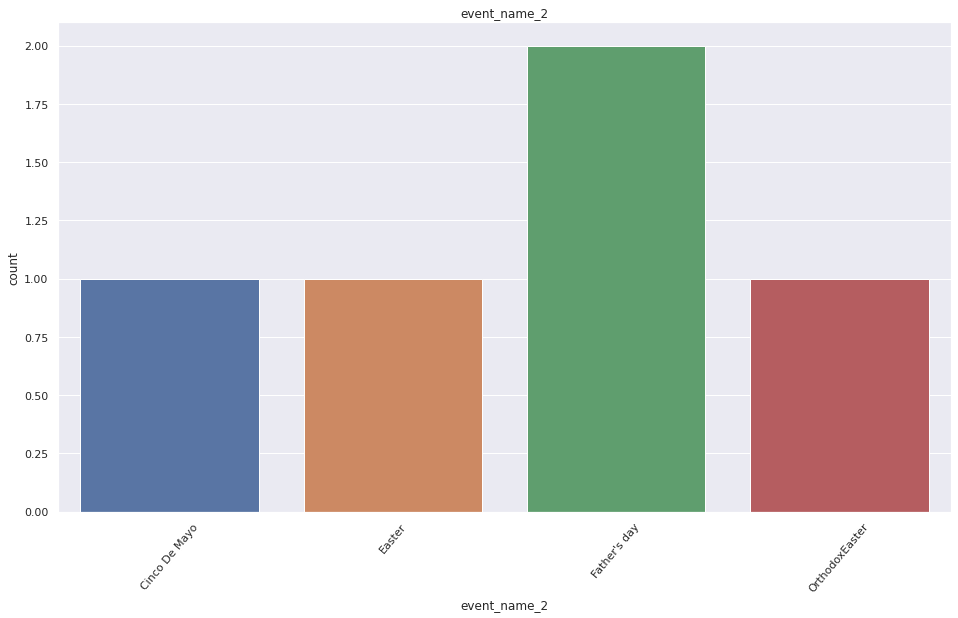

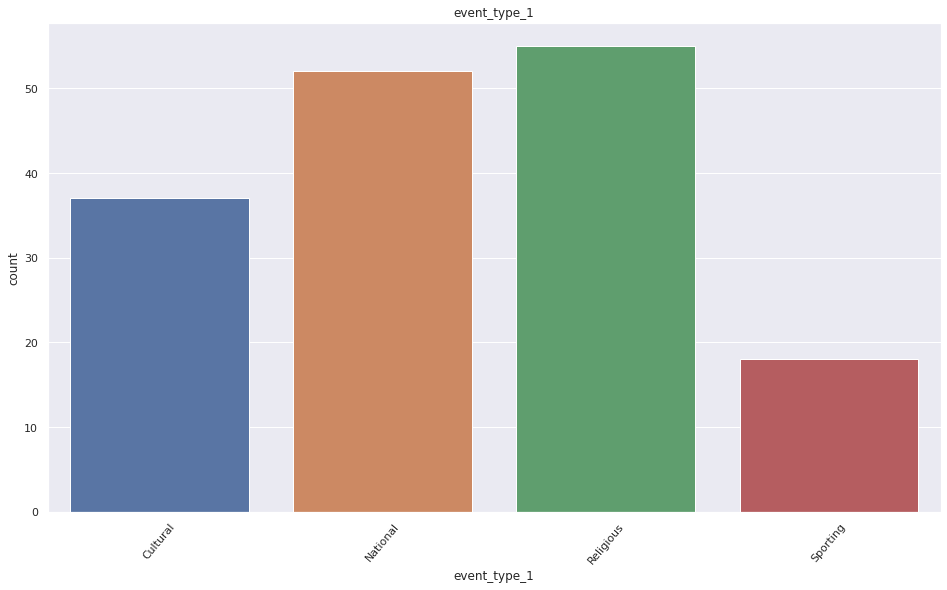

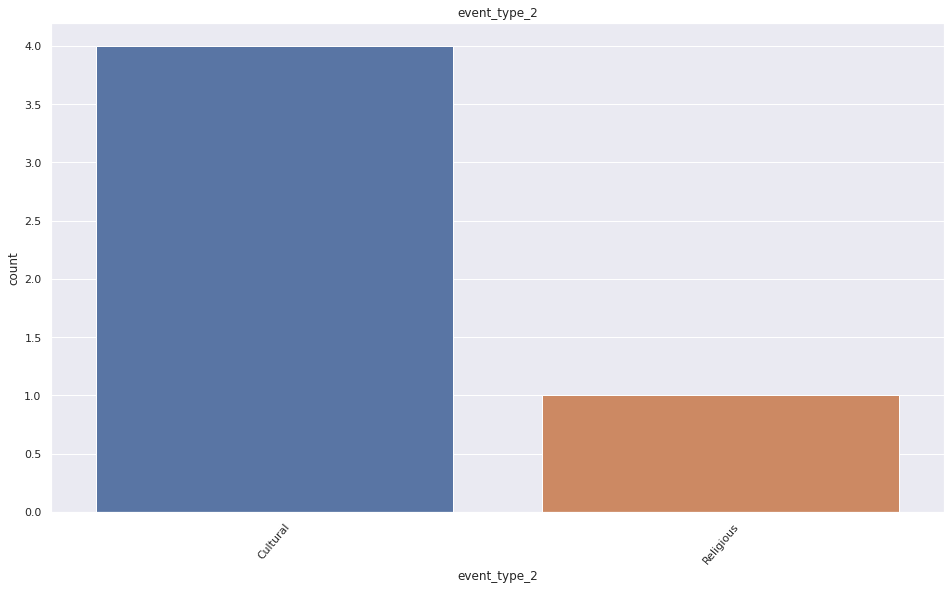

In [8]:
for feature in ['event_name_1','event_name_2','event_type_1','event_type_2']:
    sns.countplot(x=calendar[feature], data=calendar)
    plt.xticks(rotation=50)
    plt.title(feature)
    plt.show()

We see that cultural events vastly outweigh religious ones, though the former encapsulates many differing types of events. We can also see that event overlaps are incredibly rare, with only 5 entries containing more than one event.


## Sales


Notes from the official guide

File 3: “sales_train.csv” Contains the historical daily unit sales data per product and store.

    item_id: The id of the product.
    dept_id: The id of the department the product belongs to.
    cat_id: The id of the category the product belongs to.
    store_id: The id of the store where the product is sold.
    state_id: The State where the store is located.
    d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29.



In [9]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [10]:
sales.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,...,1.445490,1.781174,1.965267,1.389374,1.271794,1.216661,1.212299,1.395605,1.689669,1.782158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,...,3.656824,4.426550,4.706284,3.313292,3.126178,3.000348,2.955910,3.514318,4.089208,4.284356
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,360.000000,436.000000,207.000000,323.000000,296.000000,314.000000,316.000000,370.000000,385.000000,353.000000,...,143.000000,156.000000,187.000000,98.000000,90.000000,77.000000,84.000000,110.000000,156.000000,117.000000


In [11]:
# Let us check for any missing values
sales.isna().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1937      0
d_1938      0
d_1939      0
d_1940      0
d_1941      0
Length: 1947, dtype: int64

In [12]:
sales.isna().sum().sum()

0

The dataframe seems to have all entries of interest to us, we will now focus on analyzing the relevance of product categories and locational differences.

### Total Sales over the provided time period

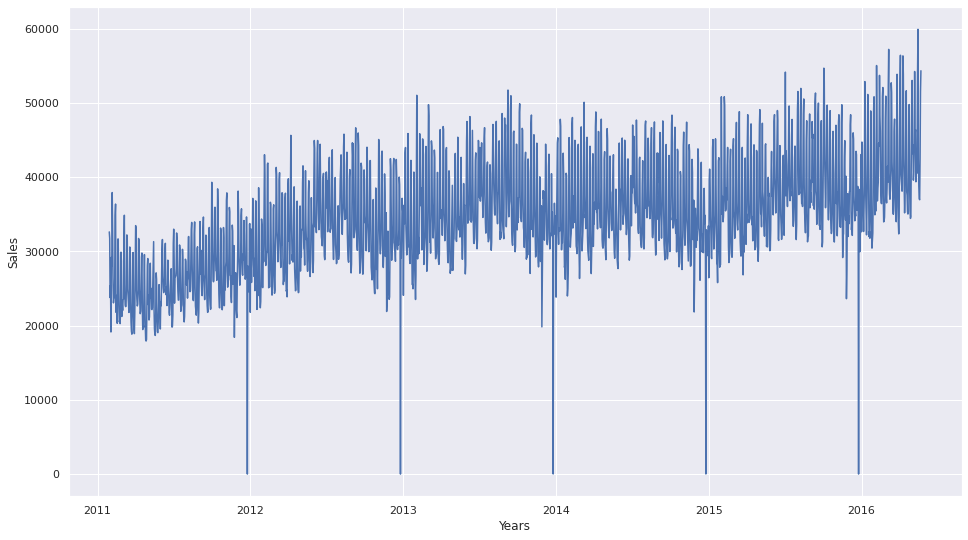

In [13]:
# Let us check how sales varied over the course of the provided years
date = calendar.loc[:1940,'date']
d_ = [i for i in sales.columns.values if 'd_' in i]
temp = pd.DataFrame({'Years':date, "Sales":sales[d_].sum(axis=0).values})
fig = sns.lineplot(data=temp, x="Years", y="Sales")

As we can see sales vary depending on the time of the year, with sales usually spiking in the first and third quarter. We can also notice that Walmart seems to be closed during Christmas. There is a smooth upwards trend in total sales.


### Sales by state

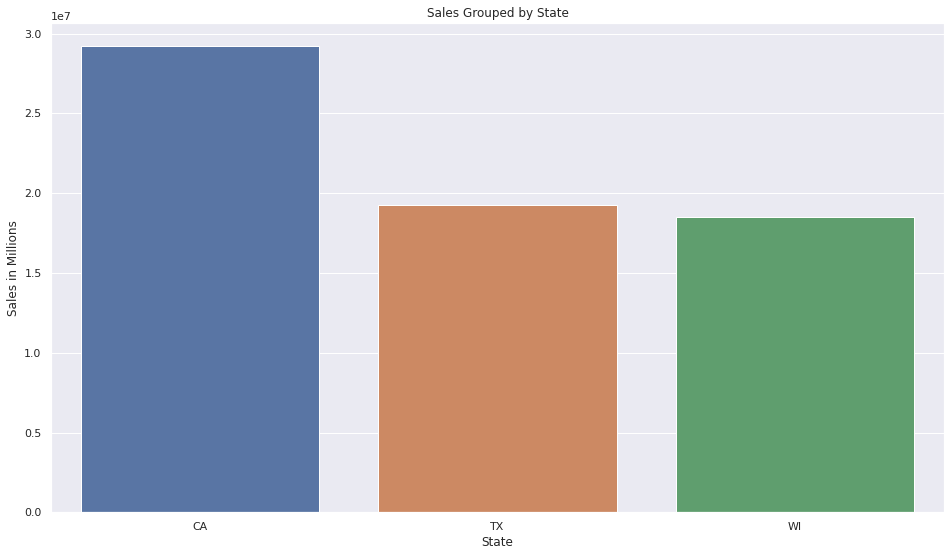

In [14]:
# Let us group up values by category, sum them up, and then sum them again to get total sales value
tmp = sales.groupby('state_id')[d_].sum().sum(axis=1)

# Creating a dataframe for plotting
tmp = pd.DataFrame({'state':tmp.index,"values":tmp.values})

fig = sns.barplot(x=tmp['state'], y=tmp['values'])
plt.title('Sales Grouped by State')
plt.xlabel('State')
plt.ylabel('Sales in Millions')
plt.show()

In order to accurately assess the validity of our initial assumptions, we should introduce some additional data to provide necessary context. These values pertain to the state's total population numbers, as well as median incomes to assess wealth. We will use values from July 2014 which lies roughly in the middle of our dataset:

#### California
Population: 38,802,500

Median income per household: $61,933

#### Texas
Population: 26,956,958

Median income per household: $53,035

#### Wisconsin
Population: 5,757,564

Median income per household: $52,622



_Source: U.S. Census Bureau_





California sees significantly more sales than the other two states, however the values Texas and Wisconsin are very similar, despite large differences in the population of each state. This lends cradence to the hypothesis that population density in the vacinity of the provided stores is a dominant factor when it comes to total sales, rather than simply total population. Median income per household does seem to line up with our data to some degree, although just by how much is difficult to judge given our relatively small sample size in terms of stores/states.

In order to get a better understanding, let us compare sales values for each store individually.

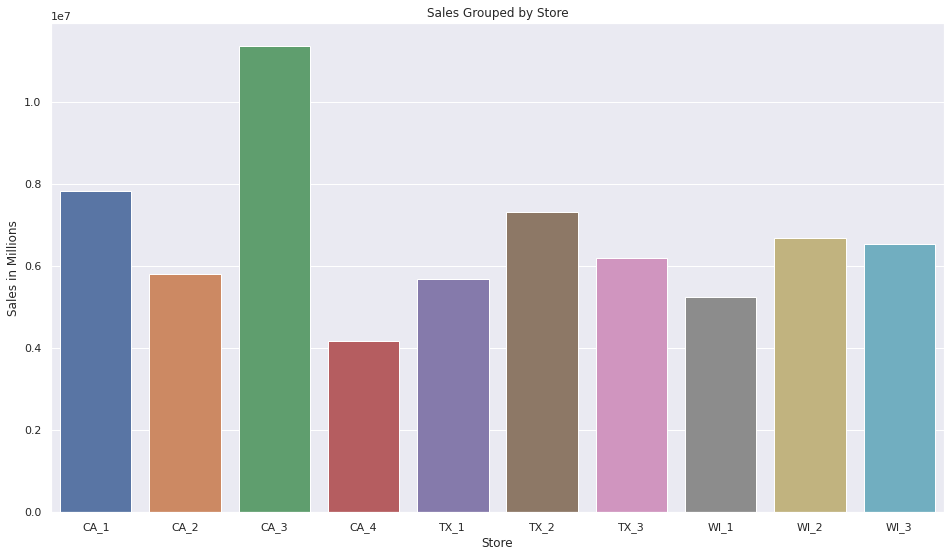

In [15]:
tmp = sales.groupby('store_id')[d_].sum().sum(axis=1)
tmp = pd.DataFrame({'store':tmp.index,"values":tmp.values})

fig = sns.barplot(x=tmp['store'], y=tmp['values'])
plt.title('Sales Grouped by Store')
plt.xlabel('Store')
plt.ylabel('Sales in Millions')
plt.show()

We can see that while the stores in Texas and Wisconsin have rather consistent total sales, the stores in California vary wildly. Store CA_3 has nearly triple of the total sales of store CA_4, both of which lie at the respective ends of the spectrum. Overall all four CA stores have very different value. This basically confirms our population density hypothesis, but also renders the knowledge provided by knowing the state moot when it comes to stores in located in CA specifically. With a larger store representation this could be examined to a better degree, sadly that is outside of the scope of this analysis.

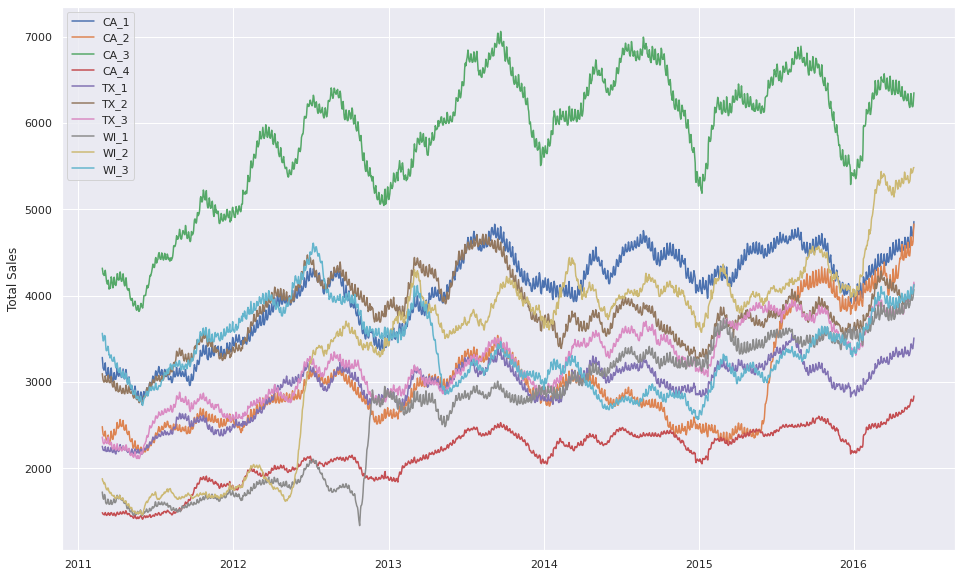

In [16]:
#Lots of manipulations in order to plot sales/store on a time axis via merging with calendar dates. 
#Theres probably a 50x simpler way to do it but eh
sales_stores= sales.groupby('store_id').sum().loc[:, "d_1":].T.merge(calendar, right_on='d', left_index=True, how='left').set_index('date')

stores = sales_stores.columns[:10]

fig, ax = plt.subplots(1, 1, figsize=(16,10))

for i, store in enumerate(stores):
    ax.plot(sales_stores.index, sales_stores[store].rolling(30).mean(), label='{}'.format(store))
    ax.set_ylabel('Total Sales')
ax.legend()
plt.show()

Most stores have peaks/valleys at similar times, the amplitude of which seems proporitonal to the value itself, as one would expect. That being said, Wisconsin sctores display a somewhat different behaviour in the early years, with WI_1 and WI_2 seeing massive rises in 2012.

### Sales by category

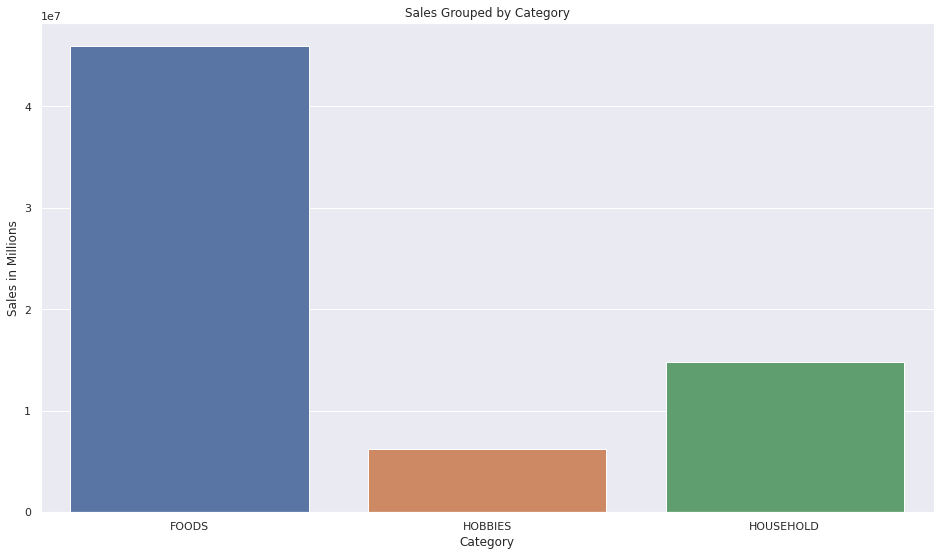

In [17]:
tmp = sales.groupby('cat_id')[d_].sum().sum(axis=1)
tmp = pd.DataFrame({'category':tmp.index,"values":tmp.values})

fig = sns.barplot(x=tmp['category'], y=tmp['values'])
plt.title('Sales Grouped by Category')
plt.xlabel('Category')
plt.ylabel('Sales in Millions')
plt.show()

Clearly foods are the dominant category in terms of sales, while hobbies play a rather small factor. Household appliances, while relevant, make up less than a third of the food sales. In order to get a better understanding, we can now check how these values are broken down into specific departments.

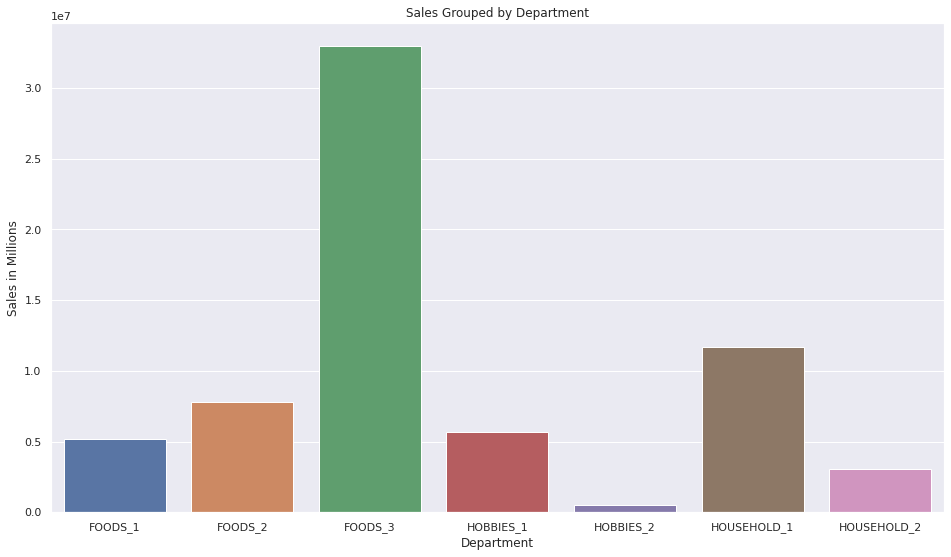

In [18]:
tmp = sales.groupby('dept_id')[d_].sum().sum(axis=1)
tmp = pd.DataFrame({'dept':tmp.index,"values":tmp.values})
fig = sns.barplot(x=tmp['dept'], y=tmp['values'])
plt.title('Sales Grouped by Department')
plt.xlabel('Department')
plt.ylabel('Sales in Millions')
plt.show()

As we can see, the vast majority of our sales comes from a single department, namely FOODS_3. The two other food departments, while relevant, are on par with some of the other departments, with HOUSEHOLD_1 actually being the second most sold department. HOBBIES_2 is ultimately almost irrelevant, with almost no sales to speak of.

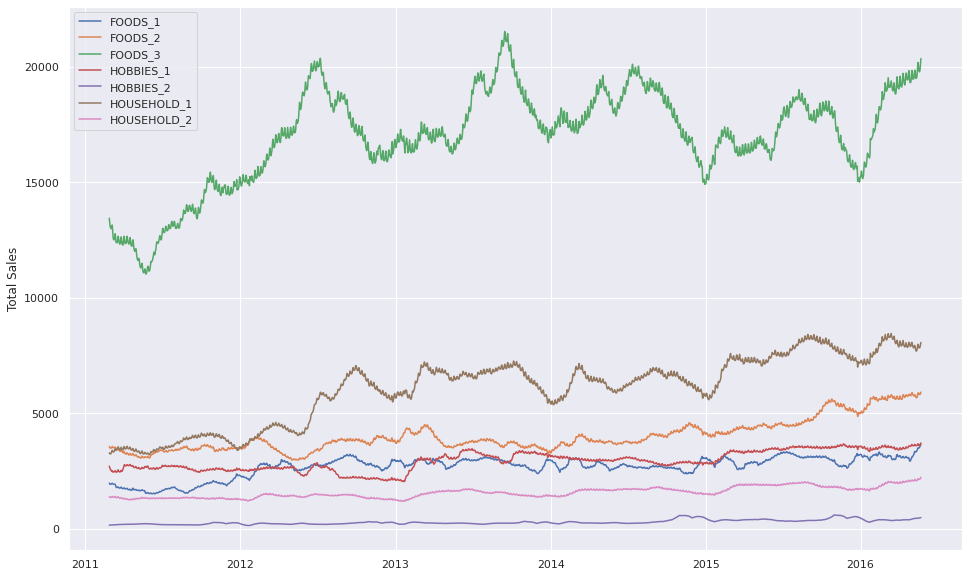

In [19]:
sales_dept= sales.groupby('dept_id').sum().loc[:, "d_1":].T.merge(calendar, right_on='d', left_index=True, how='left').set_index('date')

stores = sales_dept.columns[:7]

fig, ax = plt.subplots(1, 1, figsize=(16,10))

for i, store in enumerate(stores):
    ax.plot(sales_dept.index, sales_dept[store].rolling(30).mean(), label='{}'.format(store))
    ax.set_ylabel('Total Sales')
ax.legend()
plt.show()

Sales of products from most different departments seem to be relatively stable. FOOD_3 sees the most change, spiking around summer time and dipping in winter. This probably means it is some form of seasonal food, like fruits or vegetables. HOUSEHOLD_1 also sees similar changes that mirror those of FOOD_3, albeit with a smaller amplitude. As of right now, I don't have a good hypothesis as to why that is. All other departments are as close to linear as you could get, which means there weren't changes in overall spending. This implies some seasonal trend for HOUSEHOLD_1 as well, though I do not understand the field enough to know why that is.

### Dependancy on time

We now want to look at how our sales behave in relation to weekday and months, as we have identified these to be the main factors that could relate to our sales.

In [20]:
# We will now add an additional column to our calendar dataframe, which will track the total sales on each day.

# This line of code isolates the d_i part of the sales dataframe, sums it up by column and converts it
# to a list in order to be added as a column to the calendar dataframe. It's not how code should be written
# due to it's poor readability, but I just wanted to have some fun. Please don't judge.

calendar_sales = pd.DataFrame(calendar.iloc[:1941]).assign(total_sales=list(pd.DataFrame(sales).iloc[:, 6:].sum()))
calendar_sales

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,total_sales
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,32631
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,31749
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,23783
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,25412
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,19146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,2016-05-18,11616,Wednesday,5,5,2016,d_1937,NaN,NaN,NaN,NaN,0,0,0,37096
1937,2016-05-19,11616,Thursday,6,5,2016,d_1938,NaN,NaN,NaN,NaN,0,0,0,36963
1938,2016-05-20,11616,Friday,7,5,2016,d_1939,NaN,NaN,NaN,NaN,0,0,0,42552
1939,2016-05-21,11617,Saturday,1,5,2016,d_1940,NaN,NaN,NaN,NaN,0,0,0,51518


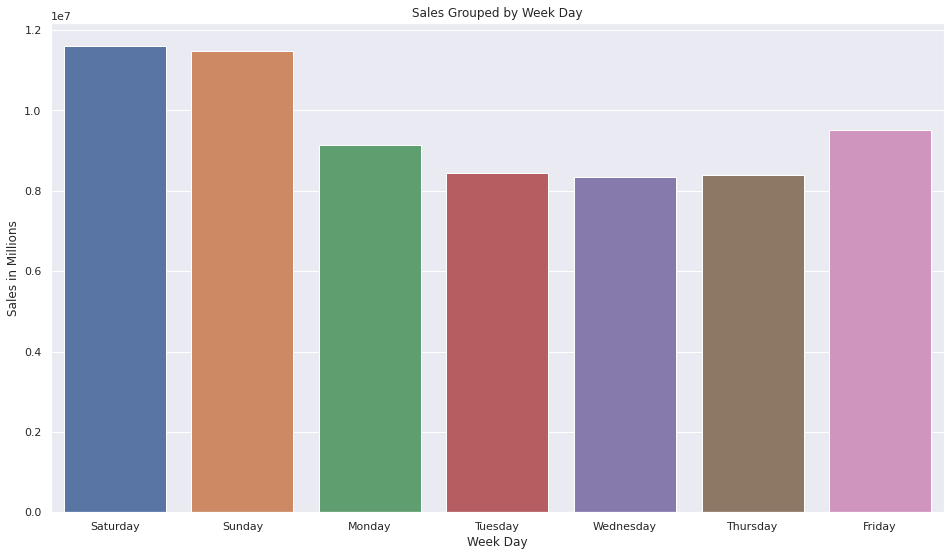

In [21]:
tmp = calendar_sales.groupby('weekday', sort=False)['total_sales'].sum()
tmp = pd.DataFrame({'weekday':tmp.index,"wday_total_sales":tmp.values})
fig = sns.barplot(x=tmp['weekday'], y=tmp['wday_total_sales'])
plt.title('Sales Grouped by Week Day')
plt.xlabel('Week Day')
plt.ylabel('Sales in Millions')
plt.show()

As we can see, sales are at their peak during the weekends. Both Friday and Monday, days before and after the weekend respectively, have somewhat hightened sales, while the other 3 days have no specific outliers. This is in line with our initial hypothesis. Let us now take a look at the months.

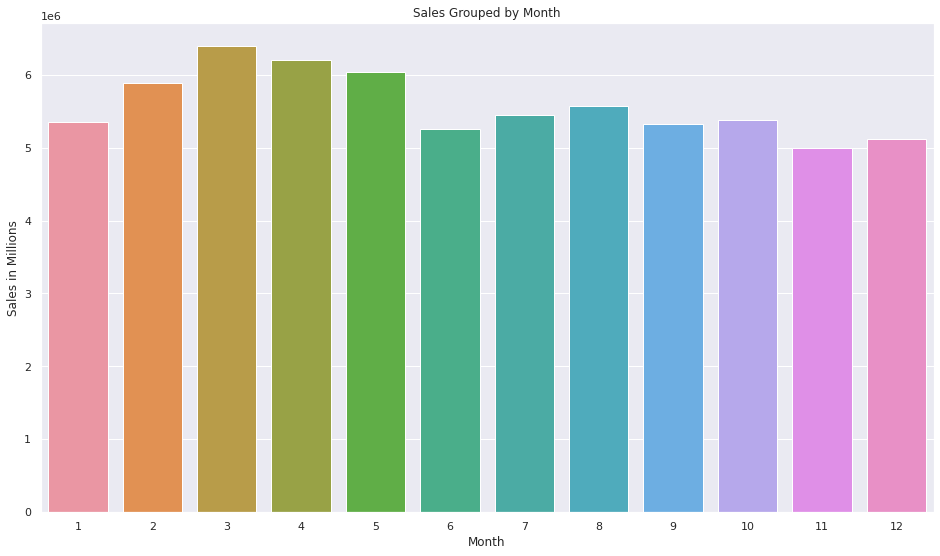

,month,month_total_sales
0,1,5345511
1,2,5889589
2,3,6387210
3,4,6197793
4,5,6033079
5,6,5250212
6,7,5443975
7,8,5571730
8,9,5321889
9,10,5380589


In [22]:
tmp = calendar_sales.groupby('month', sort=False)['total_sales'].sum()
tmp = pd.DataFrame({'month':tmp.index,"month_total_sales":tmp.values})
fig = sns.barplot(x=tmp['month'], y=tmp['month_total_sales'])
plt.title('Sales Grouped by Month')
plt.xlabel('Month')
plt.ylabel('Sales in Millions')
plt.show()
tmp

As we can see there is a vaguely sinusoidal trend, with summer and winter seeing lower sales, whilst spring specifically sees a large increase in total sales.

## Sell Prices



Notes from the official guide

File 2: “sell_prices.csv” Contains information about the price of the products sold per store and date.

    store_id: The id of the store where the product is sold.
    item_id: The id of the product.
    wm_yr_wk: The id of the week.
    sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).



In [23]:
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.000000
6841117,WI_3,FOODS_3_827,11618,1.000000
6841118,WI_3,FOODS_3_827,11619,1.000000
6841119,WI_3,FOODS_3_827,11620,1.000000


In [24]:
sell_prices.isna().sum()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

In [25]:
sell_prices.describe()

,wm_yr_wk,sell_price
count,6.841121e+06,6.841121e+06
mean,1.138294e+04,NaN
std,1.486100e+02,0.000000e+00
min,1.110100e+04,1.000214e-02
25%,1.124700e+04,2.179688e+00
50%,1.141100e+04,3.470703e+00
75%,1.151700e+04,5.839844e+00
max,1.162100e+04,1.073125e+02


<AxesSubplot:xlabel='cat_id', ylabel='sell_price'>

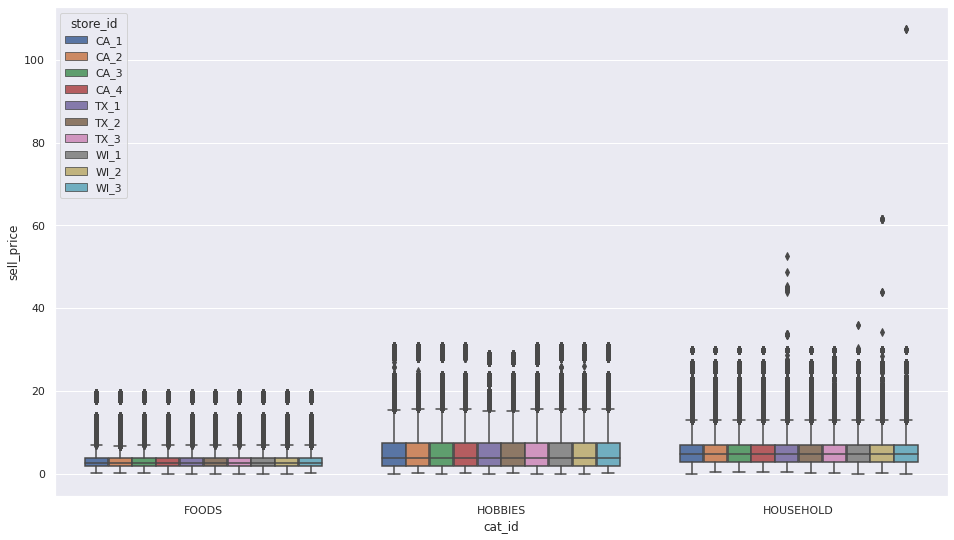

In [26]:
fig, ax = plt.subplots(1, 1)
tmp = sell_prices.merge(sales[['item_id', 'cat_id', 'store_id']], on=['item_id', 'store_id'])
sns.boxplot(data=tmp, x='cat_id', y='sell_price', hue='store_id', order=['FOODS', 'HOBBIES', 'HOUSEHOLD'], ax=ax)

Prices tend to remain consistent throughout all stores, with foods remaining at a rather constant price throughout. Hobbie prices do experience larger changes, but they remain relatively stable between stores. Household appliances generally do not diverge much more than hobbies, however they have several massive outliers, specifically in the TX_1 and WI_2 stores.

### Sample submission

In [27]:
sample_submission = pd.read_csv('input/sample_submission.csv')
sample_submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This format shall be used to generate a valid submission